In [1]:
# Import libraries
# Standard library imports
import math  # Math functions
import os  # Operating system-related functions
import pickle  # Object serialization
from datetime import datetime, timedelta  # Date and time handling

# External library imports
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting
from matplotlib.patches import Wedge  # Patch shapes
from matplotlib.colors import LogNorm  # Log normalization for colormaps
from matplotlib.ticker import LogLocator, LogFormatterSciNotation  # Logarithmic tick handling
import matplotlib.dates as mdates  # Date formatting for matplotlib plots
import matplotlib.dates as md  # Alias for mdates
from scipy.optimize import curve_fit  # Curve fittpiing
from scipy.fft import fft, fftfreq  # Fast Fourier Transform
from scipy.ndimage import gaussian_filter1d  # 1D Gaussian filter
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter
from cmap import Colormap
from scipy.interpolate import interp1d

# Tecplot imports
import tecplot as tp  # Tecplot library
from tecplot.constant import PlotType  # Tecplot plot types

# Other external libraries
import re  # Regular expressions
from os import listdir  # Directory listing
from os.path import isfile, join  # Path operations
from itertools import zip_longest  # Iterator for long zip
from collections import defaultdict  # Dictionary subclass for default values
import juliandate  # Julian date conversions
from scipy.optimize import curve_fit
#from astropy.time import Time  # Time conversions and handling

# FOr wave analysis:
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FixedLocator
import bottleneck as bn
import pywt
import ssqueezepy


In [2]:
# Define constants
amu = 1.67e-27
m_p = amu
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440
M_M = -200.9 #nT R_M^3
e = 1.602e-19

In [ ]:
# Define functions

# Load a PDS dataset and return a big numpy array with all the data
def read_mag(path,highres=False):
    # First, get all the files in the directory
    all_files = [f for f in listdir(path) if isfile(join(path, f))]
    # Then use regex to pick out the .tab file
    for i in all_files:
        match = re.search(".*\.TAB",i)
        if match != None:
            file = str(path+"/"+i)
    if highres:
        print("Reading highres data:",path)
        colnames=['year','DAY_OF_YEAR','hour','minute','second','TIME_TAG','X','Y','Z','B_x','B_y','B_z']
    else:
        print("Reading lowres data:",path)
        colnames=['year','DAY_OF_YEAR','hour','minute','second','TIME_TAG','NAVG','X','Y','Z','B_x','B_y','B_z','DBX','DBY','DBZ']
    df = pd.read_csv(file, delimiter=r"\s+", names=colnames, header=None)
    return df

def calc_B_xdip(X,Y,Z):
    # COORDINATES IN KM, AS READ IN FROM DATA
    # OUTPUT IN NT
    Z1 = Z - 0.2*R_M
    R = np.sqrt(X**2+Y**2+Z1**2)
    return 3*M_M * X * Z1/R**5 * (R_M**3)

def calc_B_ydip(X,Y,Z):
    # COORDINATES IN KM, AS READ IN FROM DATA
    # OUTPUT IN NT
    Z1 = Z - 0.2*R_M
    R = np.sqrt(X**2+Y**2+Z1**2)
    return 3*M_M * Y * Z1/R**5 * (R_M**3)

def calc_B_zdip(X,Y,Z):
    # COORDINATES IN KM, AS READ IN FROM DATA
    # OUTPUT IN NT
    Z1 = Z - 0.2*R_M
    R = np.sqrt(X**2+Y**2+Z1**2)
    return M_M * (3*Z1**2 - R**2) / R**5 * (R_M**3)

# Read in GRS and do the huge amount of work required to turn the data into something usable. summing states how many channels to summing over (i.e summing=100 means 100*0.01ms = 1s)

def read_GRS(path,summing = 6000):
    # Define the dataframe we actually want/need
    template = {'timestamp': [], 'counts': [] } #'year': [], 'month': [], 'day': [], 'hour': [], 'minute': [], 'second': [], 'counts': []}
    GRS = pd.DataFrame(data=template)
    # First, get all the subfolders (representing months)
    # months = [ f.path for f in os.scandir(path) if f.is_dir() ]
    # Iterate through all months
    # for month_dir in months: 
    all_files = [f for f in listdir(path) if isfile(join(path, f))]
    # Iterate through all .tab files
    for i in all_files:
        match = re.search(".*\.tab",i)
        if match != None:
            # Get filename
            file = str(path+i)
            print("reading file:",file)
            # Read in data as temp, ugly dataframe
            data = pd.read_csv(file, delimiter = r"\s+", header=None)
            #print(data)
            # Step through each row, representing 1800s of data (which for some reason is stored as many columns rather than subsequent rows)
            for batch in range(len(data[1])):
                if batch%100==0:
                    print("processing batch#",batch)
                # Convert to a useable time system
                ye,mo,da,ho,mi,se,micro = juliandate.to_gregorian(data[1][batch]) #(note micro is microseconds, which we subsequently convert to milliseconds)
                # Carefully structure the time object
                base_time = datetime(year=ye, month=mo, day=da, hour=ho, minute=mi, second=int(se), microsecond=int(micro))
                for channel in np.arange(91,16425-summing,summing): # This loops over each n=summing channels to group together. Skip first 50.
                    sum_counts = 0
                    zeros = 0
                    for sum_channel in range(summing):
                        sum_counts+=data[(channel+sum_channel)][batch]
                        if data[(channel+sum_channel)][batch]==0:
                            zeros+=1
                    # Create a timedelta for the milliseconds
                    delta = timedelta(milliseconds=int((channel-41)*10))
                    # Add the timedelta to the base time
                    new_time = base_time + delta
                    #print("base time:",base_time)
                    #print("new time:",new_time)
                    # Sae
                    if zeros==0: # Quick fix to deal with the complicated fact that new batches are started before old one finished
                        GRS.loc[len(GRS)] = [new_time,sum_counts]
                    #GRS.loc[len(GRS)] = [new_time,ye,mo,da,new_time.hour,new_time.minute,new_time.second + new_time.microsecond / 1_000_000,sum_counts]
    return GRS

# Read in GRS and do the huge amount of work required to turn the data into something usable. summing states how many channels to summing over (i.e summing=100 means 100*0.01ms = 1s)
def read_GRS2(path):
    # Define the dataframe we actually want/need
    template = {'timestamp': [], 'counts': [] } #'year': [], 'month': [], 'day': [], 'hour': [], 'minute': [], 'second': [], 'counts': []}
    GRS = pd.DataFrame(data=template)
    # First, get all the subfolders (representing months)
    months = [ f.path for f in os.scandir(path) if f.is_dir() ]
    # Iterate through all months
    for month_dir in months: 
        all_files = [f for f in listdir(month_dir) if isfile(join(month_dir, f))]
        # Iterate through all .tab files
        for i in all_files:
            match = re.search(".*\.tab",i)
            if match != None:
                # Get filename
                file = str(month_dir+"/"+i)
                # Read in data as temp, ugly dataframe
                data = pd.read_csv(file, delimiter = r"\s+", header=None)
                #print(data)
                # Step through each row, representing 1800s of data (which for some reason is stored as many columns rather than subsequent rows)
                for batch in range(len(data[1])):
                    if batch%100==0:
                        print("processing batch#",batch)
                    # Convert to a useable time system
                    ye,mo,da,ho,mi,se,micro = juliandate.to_gregorian(data[1][batch]) #(note micro is microseconds, which we subsequently convert to milliseconds)
                    base_time = datetime(year=ye, month=mo, day=da, hour=ho, minute=mi, second=int(se), microsecond=int(micro))
                    GRS.loc[len(GRS)] = [base_time,data[16424][batch]]
    return GRS
        

# Compute dipole field Bz
def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

# Read in magnetic field data from a simulation file
def get_B_from_sim(filename,df):
    # This function takes the path to a 3d tecplot file and a dataframe with X,Y,Z
    # It returns the simulated B field at those points, which are added to the dataframe
    
    # Load data
    tp.session.connect()
    tp.new_layout()
    dataset = tp.data.load_tecplot(filename)
    fr = tp.active_frame()
    fr.plot_type = PlotType.Cartesian3D

    # See if there is already model data to overwrite:
    if "B_x_sim" in df:
        return df
    #else:
    # Define empty arrays
    Bx = np.zeros_like(df["X"])
    By = np.zeros_like(df["X"])
    Bz = np.zeros_like(df["X"])

    # Pull data for each. Also pulls the one point before start_time, to fix the gradients.
    for i in range(len(df)):
        result = tp.data.query.probe_at_position(df["X"].iloc[i]/R_M,df["Y"].iloc[i]/R_M,df["Z"].iloc[i]/R_M)
        if result is not None:
            Bx[i],By[i],Bz[i] = result[0][3:6] # Make sure to check that 3:6 corresponds to the B data!
        # If this is outside the bounds of the simulation data, it will be set to 0

    # Update values in df or add new columns
    df.insert(len(df.columns), "B_x_sim",Bx)
    df.insert(len(df.columns), "B_y_sim",By)
    df.insert(len(df.columns), "B_z_sim",Bz)
    
    return df

# Return a df of just the data around the current sheet centers, using either a fixed z window, or based on the Bx reversal
def extract_cs(df,criteria = "z",threshold = 0.1):
    # Extract all the data within the current sheet, as defined by the criteria
    # Critera: z - choose all points within +- threshold of z = 0.2 R_M
    if criteria == "z":
        df_slice = df[(df['Z']/R_M>=(0.2-threshold)) & (df['Z']/R_M<=(0.2+threshold)) & (df['X']<0)].reset_index()
        cs_pass = [0]
        for index in range(1,len(df_slice)):
            if df_slice["TIME_TAG"][index]-df_slice["TIME_TAG"][index-1]>1.1:
                cs_pass.append(cs_pass[index-1]+1)
            else:
                cs_pass.append(cs_pass[index-1])
        df_slice.insert(len(df_slice.columns), "cs_pass",cs_pass)

        return df_slice

    if criteria == "Bx":
        # First, downselected to the regions near the current sheet. Add cs_pass to this area
        df_slice = df[(df['Z']/R_M>=(0.2-3*threshold)) & (df['Z']/R_M<=(0.2+3*threshold)) & (df['X']<0)]
        cs_pass = [0]
        count=0
        prev_index = df_slice.index.tolist()[0]
        for index in df_slice.index.tolist()[1:]:
            if index - prev_index >1: # If we have reached a skip in the indexing
                count+=1
            cs_pass.append(count)
            prev_index = index
        df_slice.insert(len(df_slice.columns), "cs_pass",cs_pass)
        # Iterate through each pass to further filter
        all_indices = np.array(())
        for pass_num in np.unique(df_slice["cs_pass"]):
            #print("Looking for center of cs pass",pass_num)
            df_pass = df_slice[df_slice["cs_pass"]==pass_num]
            # Then find where Bx is minimum and is negative before and positive after
            # Take the square of the values so that its just magnitude
            Bx_vals = np.unique(df_pass["B_x"]**2)
            # Iterate through each value, from smallest to largest until a suitable value is found
            count=0
            while count>=0:
                index = df_pass.index[df_pass['B_x']**2 == Bx_vals[count]][0]
                if (df_slice["B_x"][index-1]<0) and (df_slice["B_x"][index+1]>0):
                    #print("Match! CS found for pass",pass_num,'at Z =',df_pass["Z"][index]/R_M)
                    # If this condition is met, find the indices corresponding to this
                    indices = df_pass.index[(df_pass["Z"] - df_pass["Z"][index])**2 < (threshold*R_M)**2].tolist() # Factor of 2 to increase how much data we return
                    all_indices = np.concatenate((all_indices, indices), axis=None)
                    count=-1
                else:
                    count+=1   
        return df_slice.loc[all_indices]

    if criteria == "harris":
        # Fit the Bx to a harris current sheet
        # First, cut down the data to the vicinity of current sheet crossings
        df_crossings = df[(df['Z']/R_M>=(0.2-3*threshold)) & (df['Z']/R_M<=(0.2+3*threshold)) & (df['X']<0)]
        cs_pass = [0]
        count=0
        prev_index = df_crossings.index.tolist()[0]
        for index in df_crossings.index.tolist()[1:]:
            if index - prev_index > 1: # If we have reached a skip in the indexing
                count+=1
            cs_pass.append(count)
            prev_index = index
        df_crossings.insert(len(df_crossings.columns), "cs_pass",cs_pass)

        return df_crossings

# All calculations of secondary terms are done here
def calculate_terms(df,use_model_data=False):
    # Compute spherical coords
    R = np.sqrt(df['X']**2+df['Y']**2+(df['Z']-0.2*R_M)**2) # km
    
    # Compute magnetic field strength
    B_mag = np.sqrt(df['B_x']**2+df['B_y']**2+df['B_z']**2) # nT

    # Compute magnetic pressure
    P_mag = B_mag**2/(2*mu_0)*1e-9 # nPa

    # Compute dipole field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    B_xdip = 3*M_M * df['X']/R_M * (df['Z']-0.2*R_M)/R_M/(R/R_M)**5
    B_ydip = 3*M_M * df['Y']/R_M * (df['Z']-0.2*R_M)/R_M/(R/R_M)**5
    B_zdip = M_M * (3*((df['Z']-0.2*R_M)/R_M)**2-(R/R_M)**2)/(R/R_M)**5
    B_dip = np.sqrt(B_xdip**2+B_ydip**2+B_zdip**2)
    P_magdip = B_dip**2/(2*mu_0)*1e-9 # Magnetic pressure of dipole field
    
    # Compute local lat/time
    lat = np.arctan(df['Z']/np.sqrt(df['X']**2+df['Y']**2))*180/np.pi
    phi = np.arctan(df['Y']/df['X'])
    local_time = phi*12/np.pi + 12 

    # Compute timestamp
    year = df['year'].to_numpy()
    daynum = df['DAY_OF_YEAR'].to_numpy()
    month_ls = []
    day_ls = []
    for i in range(len(year)):
        date = datetime.strptime(str(year[i]) + "-" + str(daynum[i]), "%Y-%j").strftime("%m-%d-%Y")
        month_ls.append(date[0:2])
        day_ls.append(date[3:5])

    # Pull MHD result values, saving timestamp first so it knows how to read the right times
    df.insert(len(df.columns), "day",day_ls)
    df.insert(len(df.columns), "month",month_ls)
    df.insert(0, "timestamp", pd.to_datetime(df[['year','day','month','hour','minute','second']]))
    if use_model_data:
        df = get_B_from_MHD(GM_output,df,start_time,end_time,"GM")
        B_xMHD = df['B_xMHD']
        B_yMHD = df['B_yMHD']
        B_zMHD = df['B_zMHD']
        B_MHD = np.sqrt(B_xMHD**2+B_yMHD**2+B_zMHD**2)
        P_magMHD = B_MHD**2/(2*mu_0)*1e-9 # Magnetic pressure of MHD result
    
    # Compute gradients:
    # Step through each cell and compute dx,dy,dz. We skip the first cell.
    dx=[0]
    dy=[0]
    dz=[0]
    dBx=[0]
    dBy=[0]
    dBz=[0]
    dB_xdip=[0]
    dB_ydip=[0]
    dB_zdip=[0]
    dP_mag=[0]
    dP_magdip=[0]
    if use_model_data:
        dB_xMHD=[0]
        dB_yMHD=[0]
        dB_zMHD=[0]
        dP_magMHD=[0]
    for i in range(1,len(df)):
        dx.append(df['X'][i]-df['X'][i-1]) #dx
        dy.append(df['Y'][i]-df['Y'][i-1])
        dz.append(df['Z'][i]-df['Z'][i-1])
        dBx.append(df['B_x'][i]-df['B_x'][i-1]) #dBx
        dBy.append(df['B_y'][i]-df['B_y'][i-1])
        dBz.append(df['B_z'][i]-df['B_z'][i-1])
        dB_xdip.append(B_xdip[i]-B_xdip[i-1]) #dBx of dipole field
        dB_ydip.append(B_ydip[i]-B_ydip[i-1])
        dB_zdip.append(B_zdip[i]-B_zdip[i-1])
        dP_mag.append(P_mag[i]-P_mag[i-1]) #dP_mag
        dP_magdip.append(P_magdip[i]-P_magdip[i-1]) #dP_mag of dipole field
        if use_model_data:
            dB_xMHD.append(B_xMHD[i]-B_xMHD[i-1]) #dBx of MHD result
            dB_yMHD.append(B_yMHD[i]-B_yMHD[i-1])
            dB_zMHD.append(B_zMHD[i]-B_zMHD[i-1])
            dP_magMHD.append(P_magMHD[i]-P_magMHD[i-1]) #dP_mag of MHD result
        #  Set the 0th element equal to the first
        if i==1:
            dx[0] = dx[i]
            dy[0] = dy[i]
            dz[0] = dz[i]
            dBx[0] = dBx[i]
            dBy[0] = dBy[i]
            dBz[0] = dBz[i]
            dB_xdip[0] = dB_xdip[i]
            dB_ydip[0] = dB_ydip[i]
            dB_zdip[0] = dB_zdip[i]
            dP_mag[0] = dP_mag[i]
            dP_magdip[0] = dP_magdip[i]
            if use_model_data:
                dB_xMHD[0] = dB_xMHD[i]
                dB_yMHD[0] = dB_yMHD[i]
                dB_zMHD[0] = dB_zMHD[i]
                dP_magMHD[0] = dP_magMHD[i]
    # Save to df
    df.insert(len(df.columns), "lat",lat)
    df.insert(len(df.columns), "local_time",local_time) 
    df.insert(len(df.columns), "B_mag",B_mag)
    df.insert(len(df.columns), "P_mag",P_mag)
    df.insert(len(df.columns), "B_xdip",B_xdip)
    df.insert(len(df.columns), "B_ydip",B_ydip)
    df.insert(len(df.columns), "B_zdip",B_zdip)
    df.insert(len(df.columns), "B_dip",B_dip)
    df.insert(len(df.columns), "P_magdip",P_magdip)
    df.insert(len(df.columns), "dX",dx)
    df.insert(len(df.columns), "dY",dy)
    df.insert(len(df.columns), "dZ",dz)
    df.insert(len(df.columns), "dB_x",dBx)
    df.insert(len(df.columns), "dB_y",dBy)
    df.insert(len(df.columns), "dB_z",dBz)
    df.insert(len(df.columns), "dB_xdip",dB_xdip)
    df.insert(len(df.columns), "dB_ydip",dB_ydip)
    df.insert(len(df.columns), "dB_zdip",dB_zdip)
    df.insert(len(df.columns), "dP_mag",dP_mag)
    df.insert(len(df.columns), "dP_magdip",dP_magdip)
    if use_model_data:
        df.insert(len(df.columns), "B_MHD",B_MHD)
        df.insert(len(df.columns), "P_magMHD",P_magMHD)
        df.insert(len(df.columns), "dB_xMHD",dB_xMHD)
        df.insert(len(df.columns), "dB_yMHD",dB_yMHD)
        df.insert(len(df.columns), "dB_zMHD",dB_zMHD)
        df.insert(len(df.columns), "dP_magMHD",dP_magMHD)
    
    # Make corrections
    df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]
    return df

def plot_cs_passes4(df,df_cs,colorbar="Bz1"):
    # Makes a nice plot of the current sheet crossings, like Jim's

    # Determine which paths are in front of the planet vs. behind
    df_noview =df[(df['X']>0)]
    df_inview =df[(df['X']<0)]# & (df['timestamp']>pd.to_datetime("2015-04-01 21:00:00")) & (df['timestamp']<pd.to_datetime("2015-04-03 13:00:00"))]
    
    # Define figure and patches
    fig, ax = plt.subplots(ncols=1,figsize=(7,5))
    p0 = plt.Circle((0, 0), 1, color='black')
    p1 = plt.Circle((0, 0), 0.99, color='lightgrey')

    plot0=ax.scatter(df_noview["Y"]/R_M,df_noview["Z"]/R_M,s=0.01,color='black',alpha=0.5)
    
    # Put in the planet
    ax.add_artist(p0)
    ax.add_artist(p1)

    # plot
    plot1=ax.scatter(df_inview["Y"]/R_M,df_inview["Z"]/R_M,s=0.01,color='black',alpha=0.5)#,c=list((df_inview['DAY_OF_YEAR']-np.min(df_inview['DAY_OF_YEAR']))),
    ax.plot([-1,1],[0.2,0.2],linestyle="dashed",color="black")
    for pass_num in range(np.max(df_cs['cs_pass'])+1):
        df_pass = df_cs[(df_cs['cs_pass']==pass_num)]
        midpoint = [df_pass["Y"][df_pass.index[len(df_pass.index)//2]]/R_M, df_pass["Z"][df_pass.index[len(df_pass.index)//2]]/R_M]
        if colorbar == "Bz1":
            plot2=ax.scatter(df_pass["Y"]/R_M,df_pass["Z"]/R_M,s=1.5,c = df_pass["B_z"]-df_pass["B_zdip"],vmin=-50,vmax=50,cmap='bwr')
            ax.plot([midpoint[0]-0.008,midpoint[0]+0.008],[midpoint[1],midpoint[1]],lw=1.8,color="yellow")
        elif colorbar == "alt":
            alt = np.sqrt(df_pass["X"]**2+df_pass["Y"]**2+df_pass["Z"]**2)/R_M - 1
            plot2=ax.scatter(df_pass["Y"]/R_M,df_pass["Z"]/R_M,s=1.5,c = alt,cmap='rainbow',vmin=0.1,vmax=0.3)
            ax.plot([midpoint[0]-0.008,midpoint[0]+0.008],[midpoint[1],midpoint[1]],lw=1.8,color="yellow")
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.2,1.2)
    ax.set_ylim(-1.2,1.2)
    ax.invert_xaxis()
    ax.set_xlabel("Y [$R_M$]")
    ax.set_ylabel("Z [$R_M$]")
    clb1 = fig.colorbar(plot2, ax=ax)
    if colorbar == "Bz1":
        clb1.ax.set_title("$B_{z,obs}-B_{z,dip}$ [nT]")
    if colorbar == "alt":
        clb1.ax.set_title("Altitude [$R_M$]")
    plt.savefig("MESSENGER_orbits.png",dpi=300)
    plt.show()
    plt.close()

def plot_Bz_minus_Bzdip(df_cs):
    # For a df_cs dataframe, generate a plot of Bz1=Bz-Bzdip for each pass to help identify DR events
    count=0
    for i in np.unique(df_cs["cs_pass"]): #[5,10,27,32]: 
        indices = np.where(df_cs["cs_pass"]==i)[0]
        plt.figure(figsize=(10,6))
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_mag"][indices],color="black")
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_dip"][indices],color="black",linestyle="dashed")
        plt.plot(df_cs['Z'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color="black")
        plt.plot(df_cs['Z'][indices],df_cs["B_zdip"][indices]*0,color="black",linestyle="dashed")
        plt.title(str("CS pass: "+str(i)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        plt.ylim(-100,100)
        if np.max(df_cs["B_z"][indices]-df_cs["B_zdip"][indices])>0:
            count+=1
        plt.show()
        plt.close()

def extract_DR_passes(df_cs,max_DR_width = 0.4):
    # For a df_cs dataframe, generate a plot of Bz1=Bz-Bzdip for each pass to help identify DR events
    count=0
    passes = {}
    # Loop through all the current sheet passes
    for i in np.unique(df_cs["cs_pass"]): #[5,10,27,32]: 
        # Work out the indices which  correspond to the dataframe entries of this flyby
        indices = np.where(df_cs["cs_pass"]==i)[0]
        # Work out the index of the cs center
        midpoint = indices[len(indices)//2]
        # Work out the indices of the max and min Z value by which Bz1<0 for DR classification 
        upper_indices = df_cs['Z'][indices].index[df_cs['Z'][indices] >= df_cs['Z'][midpoint]+max_DR_width*R_M/2].tolist()
        lower_indices = df_cs['Z'][indices].index[df_cs['Z'][indices] <= df_cs['Z'][midpoint]-max_DR_width*R_M/2].tolist()
        # In general, we don't know if we are flying south to north or vice versa; this section deals with that
        if max(upper_indices)>max(lower_indices): # South to north case
            izmax = upper_indices[0]
            izmin = lower_indices[-1]
        else:
            izmax = upper_indices[-1]
            izmin = lower_indices[0]

        # Filter 1: Bz1>0 at cs center
        if (df_cs["B_z"][midpoint]>df_cs["B_zdip"][midpoint]):
            #print("cs pass",i,"is enhanced at current sheet center ("+str(df_cs['Z'][midpoint]/R_M)+")")
            # Filter 2: Bz1<0 at max width edges
            if (df_cs["B_z"][izmax]<df_cs["B_zdip"][izmax]) and (df_cs["B_z"][izmin]<df_cs["B_zdip"][izmin]):
                # Filter 3: Check it only peaks 1-2 times in this range
                peak_count = 0
                for j in np.arange(1+min(izmin,izmax),max(izmin,izmax)):
                    if (df_cs["B_z"][j-1]<df_cs["B_zdip"][j-1]) and (df_cs["B_z"][j]>df_cs["B_zdip"][j]): # i.e if this index represents a change from Bz1<0 to Bz1>1, this is the start of a peak
                        peak_count+=1
                if peak_count<3:
                    passes[i] = indices
                '''
                # Filter 3: Bz1<0 within max_DR_width/2 of the cs center (currently redundant)
                if max(upper_indices)>max(lower_indices): # South to north case
                    if (df_cs["B_z"][midpoint:izmax]-df_cs["B_zdip"][midpoint:izmax]).min()<0 and (df_cs["B_z"][izmin:midpoint]-df_cs["B_zdip"][izmin:midpoint]).min()<0:
                        #print("cs pass",i,"also has the Bz1 decrease on the edges! It's a DR")
                        passes.append(i)
                else: 
                    if (df_cs["B_z"][izmax:midpoint]-df_cs["B_zdip"][izmax:midpoint]).min()<0 and (df_cs["B_z"][midpoint:izmin]-df_cs["B_zdip"][midpoint:izmin]).min()<0:
                        #print("cs pass",i,"also has the Bz1 decrease on the edges! It's a DR")
                        passes.append(i)
                '''
            
            #plt.plot(df_cs['timestamp'][indices],df_cs["B_mag"][indices],color="black")
        #plt.plot(df_cs['timestamp'][indices],df_cs["B_dip"][indices],color="black",linestyle="dashed")
        if i in passes:
            color='blue'
        else:
            color='red'
            
        #print("Average R for this DR:",np.mean(np.sqrt(df_cs["X"][indices]**2+df_cs["Y"][indices]**2+df_cs["Z"][indices]**2)/R_M))
        plt.figure(figsize=(10,6))
        plt.plot(df_cs['timestamp'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color=color)
        plt.plot(df_cs['timestamp'][indices],df_cs["B_mag"][indices],color=color)
        plt.plot(df_cs['timestamp'][indices],df_cs["B_zdip"][indices]*0,color='black')
        plt.plot([df_cs['timestamp'][midpoint],df_cs['timestamp'][midpoint]],[-100,100],color='black',linestyle="dashed")
        plt.plot([df_cs['timestamp'][izmax],df_cs['timestamp'][izmax]],[-100,100],color='black',linestyle="dotted")
        plt.plot([df_cs['timestamp'][izmin],df_cs['timestamp'][izmin]],[-100,100],color='black',linestyle="dotted")
        plt.title(str("CS pass: "+str(i)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        #plt.ylim(-100,100)
        if np.max(df_cs["B_z"][indices]-df_cs["B_zdip"][indices])>0:
            count+=1
        plt.show()
        plt.close()

    return passes

def plot_GRS_and_DR(df_cs,GRS,DR_dict):
    for DR in DR_dict.keys():
        indices = DR_dict[DR]
        GRS_indices = np.where((GRS["timestamp"]>df_cs["timestamp"][indices[0]]) & (GRS["timestamp"]<df_cs["timestamp"][indices[-1]]))[0]
        midpoint = indices[len(indices)//2]
        fig, ax = plt.subplots(figsize=(10,6))
        #ax2 = ax.twinx()
        ax.plot(df_cs['timestamp'][indices],df_cs["B_z"][indices]-df_cs["B_zdip"][indices],color='black')
        ax.plot(GRS['timestamp'][GRS_indices],GRS["counts"][GRS_indices],color='blue')
        #ax2.yaxis.label.set_color('blue')
        #ax2.tick_params(axis ='y', labelcolor = "blue")
        ax.plot(df_cs['timestamp'][indices],df_cs["B_zdip"][indices]*0,color='black')
        ax.plot([df_cs['timestamp'][midpoint],df_cs['timestamp'][midpoint]],[-100,100],color='black',linestyle="dashed")
        ax.set_title(str("CS pass: "+str(DR-1)+"\n starting on: "+str(df_cs["timestamp"][indices[0]])))
        ax.set_ylim(-100,100)
        #ax2.set_ylim(-10000,10000)
        plt.show()
        plt.close()

def average_datasets_with_std(datasets, x_common=None, num_points=1000):
    # Flatten all x values from datasets to determine the common x range
    all_x = np.concatenate([x for x, z in datasets])
    min_x, max_x = np.min(all_x), np.max(all_x)

    # If a custom common x grid is not provided, generate it
    if x_common is None:
        x_common = np.linspace(min_x, max_x, num_points)

    # Initialize arrays for the accumulated sums and squared differences
    z_sum = np.zeros_like(x_common)
    z_squared_sum = np.zeros_like(x_common)
    valid_counts = np.zeros_like(x_common)

    # Interpolate each dataset to the common x values and accumulate results
    for x, z in datasets:
        interp_func = interp1d(x, z, kind='linear', bounds_error=False, fill_value=np.nan)
        z_interp = interp_func(x_common)

        valid_mask = ~np.isnan(z_interp)

        z_sum[valid_mask] += z_interp[valid_mask]
        z_squared_sum[valid_mask] += z_interp[valid_mask] ** 2
        valid_counts[valid_mask] += 1

    # Compute average
    with np.errstate(invalid='ignore', divide='ignore'):  # Suppress warnings
        z_average = z_sum / valid_counts

    # Compute variance and standard deviation
    with np.errstate(invalid='ignore', divide='ignore'):  # Suppress warnings
        z_variance = (z_squared_sum / valid_counts) - (z_average ** 2)
        z_std = np.sqrt(z_variance)

    return x_common, z_average, z_std

In [4]:
# Jiutong Zhao's wavelet analysis code v2
# Insert code here, if allowed to be published

Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-20
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-21
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-22
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-23
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-24
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-25
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-26
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-27
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-28
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-29
Reading highres data: /Users/atcushen/Documents/MercuryModelling/MAG_highres/2015-03-30
Reading highres data: /Users/atc

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_11433/2001052791.py:355: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T

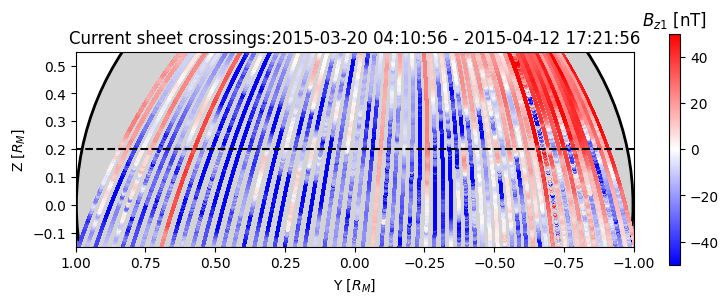

In [5]:
# Load in full time-res magnetometer data
dir = "/Users/atcushen/Documents/MercuryModelling/MAG_highres/"
#folder_ls = ["2015-03-27","2015-03-29","2015-04-05","2015-04-06"] # Events of interest
folder_ls = ["2015-03-20","2015-03-21","2015-03-22","2015-03-23","2015-03-24","2015-03-25", # All final orbits
             "2015-03-26","2015-03-27","2015-03-28","2015-03-29","2015-03-30","2015-03-31",
             "2015-04-01","2015-04-02","2015-04-03","2015-04-04","2015-04-05","2015-04-06",
             "2015-04-07","2015-04-08","2015-04-09","2015-04-10","2015-04-11","2015-04-12"]
#folder_ls = ["2011-04-09"] # Event from Boardsen et al (2015)


df = read_mag(str(dir+folder_ls[0]),highres=True)
for day in folder_ls[1:]:
    #print(day)
    df = pd.concat([df,read_mag(str(dir+day),highres=True)], ignore_index=True)

df_cs = (extract_cs(df,criteria = 'Bx', threshold = 0.5)).reset_index() #threshold = 0.3
df_cs = calculate_terms(df_cs,use_model_data=False)

# Look for where the DRs are spread
 # Determine which paths are in front of the planet vs. behind
df_noview =df[(df['X']>0)]
df_inview =df[(df['X']<0)]# & (df['timestamp']>pd.to_datetime("2015-04-01 21:00:00")) & (df['timestamp']<pd.to_datetime("2015-04-03 13:00:00"))]

# Define figure and patches
fig, ax = plt.subplots(ncols=1,figsize=(9,3))
p0 = plt.Circle((0, 0), 1, color='black')
p1 = plt.Circle((0, 0), 0.99, color='lightgrey')

#plot0=ax.scatter(df_noview["Y"]/R_M,df_noview["Z"]/R_M,s=0.01,color='black',alpha=0.5)

# Put in the planet
ax.add_artist(p0)
ax.add_artist(p1)

# plot
#plot1=ax.scatter(df_inview["Y"]/R_M,df_inview["Z"]/R_M,s=0.01,color='black',alpha=0.5)#,c=list((df_inview['DAY_OF_YEAR']-np.min(df_inview['DAY_OF_YEAR']))),
ax.plot([-1,1],[0.2,0.2],linestyle="dashed",color="black")
for pass_num in range(np.max(df_cs['cs_pass'])+1):
    df_pass = df_cs[(df_cs['cs_pass']==pass_num)]
    midpoint = [df_pass["Y"][df_pass.index[len(df_pass.index)//2]]/R_M, df_pass["Z"][df_pass.index[len(df_pass.index)//2]]/R_M]
    plot2=ax.scatter(df_pass["Y"]/R_M,df_pass["Z"]/R_M,s=1.5,c = df_pass["B_z"]-df_pass["B_zdip"],vmin=-50,vmax=50,cmap='bwr')
    #ax.plot([midpoint[0]-0.008,midpoint[0]+0.008],[midpoint[1],midpoint[1]],lw=1.8,color="yellow")
    
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1.0,1.0)
ax.set_ylim(-0.15,0.55)
ax.invert_xaxis()
ax.set_xlabel("Y [$R_M$]")
ax.set_ylabel("Z [$R_M$]")
clb1 = fig.colorbar(plot2, ax=ax)
clb1.ax.set_title("$B_{z1}$ [nT]")
ax.set_title(str("Current sheet crossings:"+str(df_cs['timestamp'][0])[:-7]+" - "+str(df_cs['timestamp'][len(df_cs)-1])[:-7]))
plt.savefig("DR_distribution.png",dpi=300)
plt.show()
plt.close()

In [ ]:
# Overview plots for paper, using wavelet code v2
#INPUT
time_average = 10*20 # how many time steps to average over (20 timesteps per sec * num of seconds)
DR_event = 22#[22,27,46,48,51]

psd_threshold = 1e-2

show_legend = True
DR_title_number = '1'

# First, compute average By for the orbits before and after
B_y_data = []

# Declare our figure
#fig, axs = plt.subplots(ncols=1, nrows=3,figsize=(12,15))

# Iterate through each pass
for event in np.unique(df_cs['cs_pass'])[DR_event-5:DR_event+5]:
    indices = np.where(df_cs['cs_pass']==event)[0]

    # Unpack data
    Z = df_cs['Z'][indices].to_numpy()
    t = df_cs['TIME_TAG'][indices].to_numpy()
    t = t - t[0]
    B_y = uniform_filter1d(df_cs['B_y'][indices],size = time_average)

    # Save an entry for Z and Bz1 for each pass
    B_y_data.append([t, B_y])
    #axs[0].plot(t, B_y, color='black')

# Compute terms for the dr event chosen
indices = np.where(df_cs['cs_pass']==DR_event)[0]

# Unpack the data
X = df_cs['X'][indices].to_numpy() #[km]
Y = df_cs['Y'][indices].to_numpy()
Z = df_cs['Z'][indices].to_numpy()
timestamp = df_cs['timestamp'][indices].to_numpy()
t = df_cs['TIME_TAG'][indices].to_numpy()
t = t - t[0]
B_x = uniform_filter1d(df_cs['B_x'][indices],size = time_average) #[nT]
B_y = uniform_filter1d(df_cs['B_y'][indices],size = time_average)
B_z = uniform_filter1d(df_cs['B_z'][indices],size = time_average)
B_xdip = calc_B_xdip(X,Y,Z)
B_ydip = calc_B_ydip(X,Y,Z)
B_zdip = calc_B_zdip(X,Y,Z)
B_mag = np.sqrt(B_x**2+B_y**2+B_z**2)
B_magdip = np.sqrt(B_xdip**2+B_ydip**2+B_zdip**2)

# Compute dipole-difference terms
B_x1 = B_x - B_xdip
B_y1 = B_y - B_ydip
B_z1 = B_z - B_zdip

# Compute differences
dX = np.insert(np.diff(X),0,np.diff(X)[0]) #np.gradient(dX)
dY = np.insert(np.diff(Y),0,np.diff(Y)[0]) #np.gradient(dY)
dZ = np.insert(np.diff(Z),0,np.diff(Z)[0]) #np.gradient(dZ)
dB_x = np.insert(np.diff(B_x),0,np.diff(B_x)[0]) # insert 0 at the front to fill the gap
dB_y = np.insert(np.diff(B_y),0,np.diff(B_y)[0])
dB_z = np.insert(np.diff(B_z),0,np.diff(B_z)[0])
dB2 = np.insert(np.diff(B_mag**2),0,np.diff(B_mag**2)[0])

# Fix the tiny dY using a mask to remove values where dY is very small
mask = np.abs(dY)<1e-2

# Compute tension subcomponents
Cx1 = B_x*dB_x/dX
Cx2 = B_y*dB_x/dY
Cx3 = B_z*dB_x/dZ
Cy1 = B_x*dB_y/dX
Cy2 = B_y*dB_y/dY
Cy3 = B_z*dB_y/dZ
Cz1 = B_x*dB_z/dX
Cz2 = B_y*dB_z/dY
Cz3 = B_z*dB_z/dZ

# Replace nans of all terms with 1/dY with 0
Cx2[mask] = 0
Cy2[mask] = 0
Cz2[mask] = 0

# Compute tension components, convert to SI (B in nT, dX in 1/km)
T_x = 1/mu_0 * (Cx1+Cx2+Cx3) * (1e-9)**2 * 1e-3
T_y = 1/mu_0 * (Cy1+Cy2+Cy3) * (1e-9)**2 * 1e-3
T_z = 1/mu_0 * (Cz1+Cz2+Cz3) * (1e-9)**2 * 1e-3

# Compute pressure gradient, convert to SI
P_grad_x = -dB2 / dX / (2*mu_0) * (1e-9)**2 * (1e-3)
P_grad_y = -dB2 / dY / (2*mu_0) * (1e-9)**2 * (1e-3)
P_grad_z = -dB2 / dZ / (2*mu_0) * (1e-9)**2 * (1e-3)

P_grad_y[mask] = 0

# Project into spacecraft motion vector
T_tot = uniform_filter1d((T_x*dX + T_y*dY + T_z*dZ)/np.sqrt(dX**2+dY**2+dZ**2), size = time_average)
P_tot = uniform_filter1d((P_grad_x*dX+P_grad_y*dY+P_grad_z*dZ)/np.sqrt(dX**2+dY**2+dZ**2), size = time_average)

# Compute Jy terms
J_ydX = (-1/mu_0)*np.gradient(B_z,X) * 1e-9 * 1e-3 
J_ydZ = (1/mu_0)*np.gradient(B_x,Z) * 1e-9 * 1e-3 
J_ydipdX = (-1/mu_0)*np.gradient(B_zdip,X) * 1e-9 * 1e-3 #- dB_z1/dX
J_ydipdZ = (1/mu_0)*np.gradient(B_xdip,Z) * 1e-9 * 1e-3 #- dB_z1/dX

# Weight terms based on our direction of motion
J_y = (J_ydX*dX + J_ydZ*dZ)/np.sqrt(dX**2+dZ**2)
J_ydip = (J_ydipdX*dX + J_ydipdZ*dZ)/np.sqrt(dX**2+dZ**2)
J_y_smooth = uniform_filter1d(J_y, size = time_average)
J_ydip_smooth = uniform_filter1d(J_ydip, size = time_average)

# Use interpolation to average over all events neighbouring the DR
t_common, B_y_average, B_y_std = average_datasets_with_std(B_y_data, x_common = t)

# Declare our figure
fig, axs = plt.subplots(ncols=1, nrows=4,figsize=(4,10), sharex=True, height_ratios=[5,3,2,2])

# Remove space between 
plt.subplots_adjust(hspace=0)

# Plot magnetic field components
#axs[0].plot(t, B_x, c = 'red', label='$B_x$')
axs[0].plot(t, B_y - B_y_average, c = 'green', label = '$\delta B_y$')
axs[0].plot(t, B_z1, c = 'blue', label = '$B_{z1}$')
axs[0].axhline(y=0, c = 'black', linestyle = 'dashed')

# Tidy up axs[0]
axs[0].grid('on')

# Show B_x on separate axis if it's too different
if DR_event in [48]:
    #axs0_1 = axs[0].twinx()
    #axs0_1.plot(t, B_x, c = 'red', label='$B_x$')
    #axs0_1.set_ylabel("$B_x$ [nT]", fontsize = 12, color='red')
    #axs0_1.tick_params(axis='both',labelsize=12)
    #axs0_1.tick_params(axis='y',color='red')
    #axs0_1.set_ylim(0,325)
    #axs[0].plot([-1e5,-1e5], [-1e5,-1e5], c = 'red', label='$B_x$')
    print("not showing Bx")
else:
    axs[0].plot(t, B_x, c = 'red', label='$B_x$')
axs[0].set_ylim(-76,56)
axs[0].set_ylabel("$B$ [nT]", fontsize = 12)
if show_legend:
    axs[0].legend(loc = 'lower right', fontsize = 12, ncol=3)
axs[0].tick_params(axis='both',labelsize=12)

# Show force balance and Jy in second panel
#axs[1].plot(t, T_tot*1e12, label = '$T_{mag}$',color='tab:blue')
#axs[1].plot(t, P_tot*1e12, label = '$-grad(p_{mag})$',color='tab:orange')
#axs[1].plot(t, (T_tot+P_tot)*1e12, label = 'Total',color='black')
axs[1].axhline(y=0, c = 'black', linestyle = 'dashed')
#axs[1].plot(0,1e10, color = 'tab:green', label = '$J_y$')
#axs1_2 = axs[1].twinx()
#axs1_2.plot(t, (J_y_smooth-J_ydip_smooth)*1e9, color = 'tab:green')
axs[1].plot(t, uniform_filter1d((J_ydX-J_ydipdX)*1e9,size = time_average), color = 'tab:blue', label='$∂B_z/∂x$',lw=0.5)
axs[1].plot(t, uniform_filter1d((J_ydZ-J_ydipdZ)*1e9,size = time_average), color = 'tab:red', label='$∂B_x/∂z$',lw=0.5)
axs[1].plot(t, uniform_filter1d((J_ydX-J_ydipdX)*1e9+(J_ydZ-J_ydipdZ)*1e9,size = time_average), color = 'black',alpha = 1,lw=0.5)
#axs[1].plot(t, gaussian_filter1d((J_ydZ-J_ydipdZ)*1e9, sigma=time_average), color = 'tab:red', linestyle='dashed')
#axs[1].plot(t, (J_y_smooth-J_ydip_smooth)*1e9, color = 'black', label = 'weighted sum')
#axs1_2.plot(t, J_ydip_smooth*1e9, color = 'tab:green', linestyle = 'dashed')

# Tidy up axs[1]
axs[1].grid('on')
#axs[1].set_ylim(-0.4,0.4)
axs[1].set_ylim(-2e3,2e3)
#axs1_2.set_ylim(-500,500)
#axs[1].set_ylabel("Force [pN/m$^3$]", fontsize = 12)
#axs1_2.set_ylabel("Current density [nA/m$^2$]", fontsize = 12)
axs[1].set_ylabel("$J_y$ [nA/m$^2$]", fontsize = 12)
axs[1].set_yscale('symlog', linthresh=1e2,linscale=1e0)
axs[1].tick_params(axis='both',labelsize=12)
if show_legend:
    axs[1].legend(loc = 'lower right', fontsize = 12, ncol=2)
#axs1_2.tick_params(axis='both',labelsize=12)

# Denote start / end of DF:
if DR_event in [47,48,60]:
    t_start_guess = 200
    t_stop_guess = 700 
elif DR_event in [28,44]:
    t_start_guess = 100
    t_stop_guess = 600 
else:
    t_start_guess = 200 # when after this time does Bz1>0
    t_stop_guess = 500 # when before this time does Bz1<0

# Find the index of start/stop
i_start = np.where((B_z1 > 0) & (t > t_start_guess))[0][0]
i_stop = np.where((B_z1 > 0) & (t < t_stop_guess))[0][-1]

# Highlight DR region
i_middle = int((i_stop + i_start) / 2)
for ax in axs:
    ax.axvspan(t[i_start],t[i_stop],color='black',alpha = 0.05) # Bz1>0 region
    ax.axvspan(t[i_middle - 60*20],t[i_middle + 60*20],color='black',alpha = 0.05) # FIPS sampling time
    ax.axvline(t[i_cs],color='black', linestyle='dashed') # equator crossing
print("DR start:",timestamp[i_middle - 60*20],"DR stop:",timestamp[i_middle + 60*20])

# Guess lower bound for cs crossing time
t_cs_start_guess = 100

# Find index of cs crossing
i_cs = np.where((B_x > 0) & (t > t_cs_start_guess))[0][0]


# Set time range
total_plot_time = 150 + (t[i_stop] - t[i_start]) # Total length of time to plot
t_before = 60 * 1.5 # How much time before DR starts to show
i_plot_start = np.where(t > t[i_start]-t_before)[0][0]
i_plot_stop = np.where(t < t[i_start]-t_before+total_plot_time)[0][-1]
for ax in axs:
    ax.set_xlim(t[i_plot_start], t[i_plot_stop])

############## COMPUTE WAVE CHARACTERISTICS #############

# Relabel data
mag_ut = df_cs["timestamp"][indices]
mag_t = df_cs["TIME_TAG"][indices] - df_cs["TIME_TAG"][indices[0]]
mag_bx = df_cs["B_x"][indices]
mag_by = df_cs["B_y"][indices]
mag_bz = df_cs["B_z"][indices]
mag_bt = mag_bt = np.sqrt(mag_bx**2+mag_by**2+mag_bz**2)
mag_bz1 = mag_bz - calc_B_zdip(df_cs["X"][indices],df_cs["Y"][indices],df_cs["Z"][indices])

#start_ut = np.datetime64('2015-03-29T12:12:00')
#end_ut = np.datetime64('2015-03-29T12:16:00')

# Convert from np index to pd index for start/stop times
start_idx = np.searchsorted(mag_ut, timestamp[0])
end_idx = np.searchsorted(mag_ut, timestamp[-1])


sig_t = np.copy(mag_t[start_idx:end_idx])
sig_ut = np.copy(mag_ut[start_idx:end_idx])
sig_bx = np.copy(mag_bx[start_idx:end_idx])
sig_by = np.copy(mag_by[start_idx:end_idx])
sig_bz = np.copy(mag_bz[start_idx:end_idx])
sig_bt = np.copy(mag_bt[start_idx:end_idx])
sig_bz1 = np.copy(mag_bz1[start_idx:end_idx])

sig_ut = np.copy(mag_ut[start_idx:end_idx])
sig_bx = np.copy(mag_bx[start_idx:end_idx])
sig_by = np.copy(mag_by[start_idx:end_idx])
sig_bz = np.copy(mag_bz[start_idx:end_idx])
sig_bt = np.copy(mag_bt[start_idx:end_idx])
sig_bz1 = np.copy(mag_bz1[start_idx:end_idx])

import scipy.signal
sos = scipy.signal.butter(10, 0.1, 'hp', fs=20, output='sos')

filtered_sig_bx = scipy.signal.sosfiltfilt(sos, sig_bx)
filtered_sig_by = scipy.signal.sosfiltfilt(sos, sig_by)
filtered_sig_bz = scipy.signal.sosfiltfilt(sos, sig_bz)
filtered_sig_bt = scipy.signal.sosfiltfilt(sos, sig_bt)

use_wavelet = True

if use_wavelet:
    bandwidth = 6.0
    # log-scale
    scales = np.power(2, np.linspace(1, 7, 1000))
    # linear-scale (for comparing with the windowed FFT)
    #scales = np.arange(2, 400)
    downsample = 1 # For comparing with the windowed FFT with a step of 50
    freq_window = 3
    time_window = 7
    downsample_signal = False # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / frequency).astype(float)
    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else: # Use windowed FFT
    step = 1
    window = 400
    
    freq_window = 3
    time_window = 7

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)
    

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

psd = (psd_bx + psd_by + psd_bz)

compressibility = (psd_bt) / psd

compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)

_mask_idx = np.where(psd < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan

# Convert to time [s] for plotting
ts = np.array((time-time[0])/1e9,dtype = 'float')

pc2 = axs[2].pcolormesh(ts, frequency, np.log10(psd), cmap='jet', shading='auto', vmax = 1.0, vmin = -3)

axs[2].grid('on')
axs[2].set_yscale('log')
axs[2].set_ylim(0.2, 5.0)


pc3 = axs[3].pcolormesh(ts, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0)
axs[3].grid('on')
axs[3].set_yscale('log')
axs[3].set_ylim(0.2, 5.0)

#pc4 = axs[4].pcolormesh(ts, frequency, ellipticity_along_b, cmap='coolwarm', vmax = 1.0, vmin = -1.0)
#axs[4].grid('on')
#axs[4].set_yscale('log')
#axs[4].set_ylim(0.2, 5.0)

# Add colorbars
cbar_ax2 = fig.add_axes(
    [axs[2].get_position().x1 + 0.01, axs[2].get_position().y0 + 0.01, 0.02, axs[2].get_position().y1 - axs[2].get_position().y0 - 0.02])
cbar2 = fig.colorbar(pc2, cax=cbar_ax2)
# cbar2.set_label('$\mathrm{log_{10}(PSD)}$\n($\mathrm{nT^2/Hz}$)')
cbar2.ax.tick_params(which='major', length=4, direction='in', pad=3)
cbar2.set_label("PSD [nT$^2$/Hz]", rotation=90,fontsize = 12)

cbar_ax3 = fig.add_axes(
    [axs[3].get_position().x1 + 0.01, axs[3].get_position().y0 + 0.01, 0.02, axs[3].get_position().y1 - axs[3].get_position().y0 - 0.02])
cbar3 = fig.colorbar(pc3, cax=cbar_ax3)
# cbar3.set_label('Compre\n-ssibility')
cbar3.ax.tick_params(which='major', length=4, direction='in', pad=3)
cbar3.set_label("Compressibility", rotation=90,fontsize = 12)

#cbar_ax4 = fig.add_axes(
#    [axs[4].get_position().x1 + 0.01, axs[4].get_position().y0 + 0.01, 0.02, axs[4].get_position().y1 - axs[4].get_position().y0 - 0.02])
#cbar4 = fig.colorbar(pc4, cax=cbar_ax4)
## cbar3.set_label('Compre\n-ssibility')
#cbar4.ax.tick_params(which='major', length=4, direction='in', pad=3)
#cbar4.set_label("Ellipticity", rotation=90,fontsize = 12)

# Add axes labels
axs[2].set_ylabel("Freq. [Hz]",fontsize=12)
axs[3].set_ylabel("Freq. [Hz]",fontsize=12)
#axs[4].set_ylabel("Freq. [Hz]",fontsize=12)

############

# Fix Horizontal axis ticks:
# Find nearest minute to start time
# Timestamp is always 29 characters long, so we can use a string method:
tick_indices = []#[i_plot_start]
tick_positions = []#[t[i_plot_start]]
tick_labels = []#["HH:MM:SS   \n$X_{MSM}$ [$R_M$]   \n$Y_{MSM}$ [$R_M$]   \n$Z_{MSM}$ [$R_M$]   "]

for i in np.arange(i_plot_start,i_plot_stop):
    if str(timestamp[i])[-12:-7] == '00.04' or str(timestamp[i])[-12:-7] == '00.03' or str(timestamp[i])[-12:-7] == '00.02' or str(timestamp[i])[-12:-7] == '00.01' or str(timestamp[i])[-12:-7] == '00.00':
        tick_indices.append(i)
        tick_positions.append(t[i])
        tick_labels.append(str(str(timestamp[i])[11:-13]+'\n'+str(round(X[i]/R_M,3))+'\n'+str(round(Y[i]/R_M,3))+'\n'+str(round(Z[i]/R_M-0.2,3))))

# Show major ticks
axs[3].set_xticks(tick_positions, tick_labels, fontsize=12)

# Show minor ticks
minor_ticks = np.arange(t[tick_indices[1]-20*60], np.max(t), 15)
minor_locator = FixedLocator(minor_ticks)
axs[3].xaxis.set_minor_locator(minor_locator)

# Set title:
axs[0].set_title(str("DR"+DR_title_number+": "+str(timestamp[i_plot_start])[:10]),fontsize=12)

fig.savefig(str('DR_'+str(DR_event)+'_overview.png'),bbox_inches='tight', dpi=300)
plt.show()
#print(f'Common x: {x_common}')
#print(f'Average z: {z_average}')
